<a href="https://colab.research.google.com/github/kscoder27/Stock-Price-Prediction-using-machine-learning/blob/main/MinorFinalStockCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Concatenate, Input, Flatten
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('S&P500Dataset10.csv')  # Replace with your file path
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Clean the Price column by removing commas and converting to float
df['Price'] = df['Price'].str.replace(',', '').astype(float)

# Extract the closing price data
data = df['Price'].values.reshape(-1, 1)

In [ ]:
data = df['Price'].values.reshape(-1, 1)

def prepare_data(data, sequence_length=60):
    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Create sequences
    X, y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:(i + sequence_length)])
        y.append(scaled_data[i + sequence_length])

    X = np.array(X)
    y = np.array(y)

    # Split into train and test sets (80-20 split)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    return X_train, X_test, y_train, y_test, scaler

In [ ]:
def build_hybrid_model(sequence_length):
    # CNN branch
    cnn_input = Input(shape=(sequence_length, 1))
    conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn_input)
    pool1 = MaxPooling1D(pool_size=2)(conv1)
    conv2 = Conv1D(filters=32, kernel_size=3, activation='relu')(pool1)
    pool2 = MaxPooling1D(pool_size=2)(conv2)
    cnn_flat = Flatten()(pool2)

    # LSTM branch
    lstm_input = Input(shape=(sequence_length, 1))
    lstm1 = LSTM(50, return_sequences=True)(lstm_input)
    lstm2 = LSTM(25)(lstm1)

    # Combine CNN and LSTM
    combined = Concatenate()([cnn_flat, lstm2])
    dense1 = Dense(20, activation='relu')(combined)
    output = Dense(1)(dense1)

    model = Model(inputs=[cnn_input, lstm_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
sequence_length = 60
X_train, X_test, y_train, y_test, scaler = prepare_data(data, sequence_length)

# Build and train the hybrid model
model = build_hybrid_model(sequence_length)
history = model.fit(
    [X_train, X_train], y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0111 - val_loss: 0.0047
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 8.2319e-04 - val_loss: 0.0040
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 6.2817e-04 - val_loss: 0.0033
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 7.7084e-04 - val_loss: 0.0039
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 4.3692e-04 - val_loss: 0.0038
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 3.5839e-04 - val_loss: 0.0019
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 3.7737e-04 - val_loss: 0.0022
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 3.1501e-04 - val_loss: 0.0012
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 2.6405e-04 - val_loss: 0.0015
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 2.3118e-04 - val_loss: 0.0010
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 2.7403e-04 - val_loss: 0.0011
Epoch 12/50
56/56 ━━━━━

In [ ]:
predictions = model.predict([X_test, X_test])

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
residuals_train = y_train - model.predict([X_train, X_train])
rf_model.fit(X_train.reshape(X_train.shape[0], -1), residuals_train)

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


RandomForestRegressor(random_state=42)

In [ ]:
rf_predictions = rf_model.predict(X_test.reshape(X_test.shape[0], -1))
final_predictions = predictions + rf_predictions.reshape(-1, 1)

In [ ]:
y_test_inv = scaler.inverse_transform(y_test)
predictions_inv = scaler.inverse_transform(final_predictions)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_inv, predictions_inv))
mae = mean_absolute_error(y_test_inv, predictions_inv)
r2 = r2_score(y_test_inv, predictions_inv)
mape = np.mean(np.abs((y_test_inv - predictions_inv) / y_test_inv)) * 100

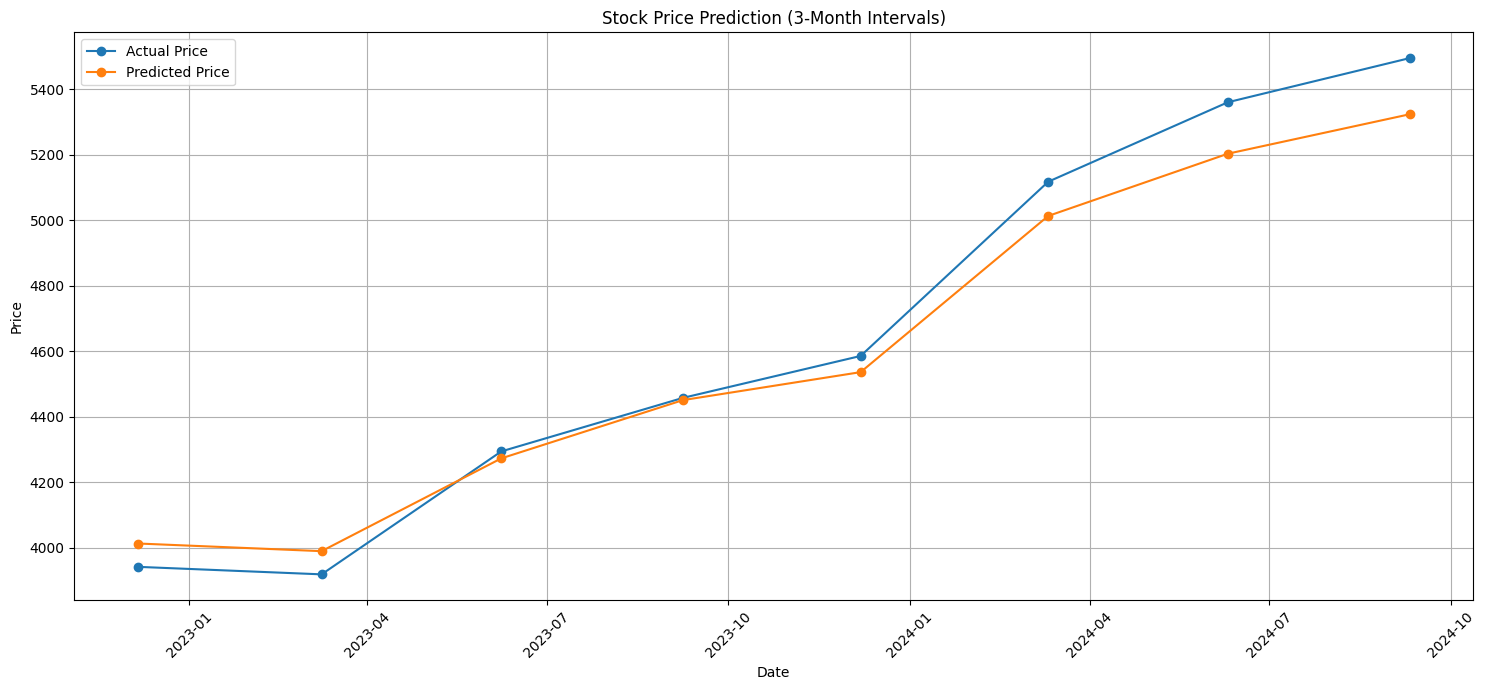


Model Performance Metrics:
RMSE: $111.05
MAE: $85.23
MAPE: 1.66%
R-squared: 0.9682


In [ ]:
sample_interval = 63
y_test_sampled = y_test_inv[::sample_interval]
predictions_sampled = predictions_inv[::sample_interval]

# Get corresponding dates for the test set
test_dates = df['Date'].values[-len(y_test_inv):][::sample_interval]

# Plotting
plt.figure(figsize=(15, 7))
plt.plot(test_dates, y_test_sampled, label='Actual Price', marker='o')
plt.plot(test_dates, predictions_sampled, label='Predicted Price', marker='o')
plt.title('Stock Price Prediction (3-Month Intervals)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Print metrics
print(f"\nModel Performance Metrics:")
print(f"RMSE: ${rmse:.2f}")
print(f"MAE: ${mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R-squared: {r2:.4f}")